In [1]:
!pip install transformers datasets torch scikit-learn pandas matplotlib seaborn kaggle

In [2]:
from google.colab import files
files.upload()  # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juhinahb","key":"262c35bee313cf4845353b04003cadff"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download faiqahmad01/emotion-categories-neutraljoysadnessanger

Dataset URL: https://www.kaggle.com/datasets/faiqahmad01/emotion-categories-neutraljoysadnessanger
License(s): apache-2.0
  0% 0.00/629k [00:00<?, ?B/s]
100% 629k/629k [00:00<00:00, 1.33GB/s]


In [5]:
!unzip emotion-categories-neutraljoysadnessanger.zip -d ./emotion_dat

Archive:  emotion-categories-neutraljoysadnessanger.zip
  inflating: ./emotion_dat/emotion_labels.csv  
  inflating: ./emotion_dat/emotions-dataset.csv  


In [6]:
import pandas as pd
# Load both CSVs
data_text = pd.read_csv("/content/emotion_dat/emotions-dataset.csv")   # (content, sentiments)
data_labels = pd.read_csv("/content/emotion_dat/emotion_labels.csv")    # (label, emotion)

In [9]:
# Merge them on sentiments = label
data = pd.merge(data_text, data_labels, left_on='sentiment', right_on='label')


In [10]:
# Keep only required columns
data = data[['content', 'emotion']].rename(columns={'content': 'text'})

# Drop missing values or duplicates if any
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

data.head()

,text,emotion
0,not a very good day at the house,Sadness
1,tommcfly i saw you on tues and last niiiighht ...,Neutral
2,i dont even understand the intro to this book,Anger
3,happy mothers day mommy and grandma haha ily,Joy
4,quotoh i got so fucked up last nightquot but u...,Anger


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['label'] = le.fit_transform(data['emotion'])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['text'].values, data['label'].values,
    test_size=0.2, random_state=42, stratify=data['label']
)

num_labels = len(le.classes_)
print("Emotion Classes:", le.classes_)


Emotion Classes: ['Anger' 'Joy' 'Neutral' 'Sadness']


In [12]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=64)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
import torch

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)


In [14]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

Accuracy: 0.6692
F1 Score: 0.6692


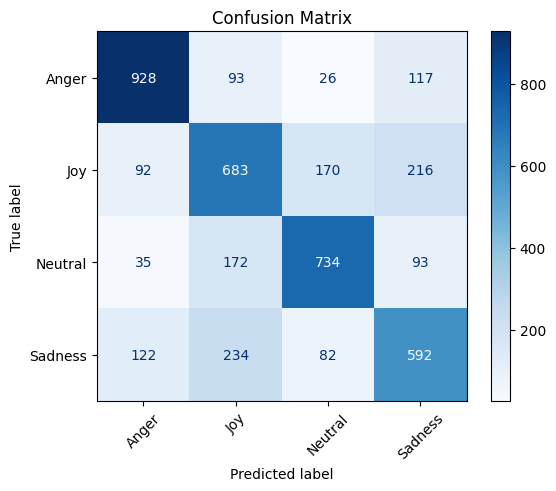

In [18]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

preds = trainer.predict(val_dataset)
y_true = val_labels
y_pred = np.argmax(preds.predictions, axis=1)

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [20]:
def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    model.to(device)  # Ensure model is also on the correct device
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    return le.classes_[pred]

examples = [
    "I am feeling so happy today!",
    "This is terrible and makes me angry.",
    "I feel empty inside.",
    "Everything is calm and normal."
]

for text in examples:
    print(f"{text} → {predict_emotion(text)}")

I am feeling so happy today! → Neutral
This is terrible and makes me angry. → Anger
I feel empty inside. → Sadness
Everything is calm and normal. → Joy


In [22]:
model.save_pretrained("/content/model")
tokenizer.save_pretrained("/content/model")

('/content/model/tokenizer_config.json',
 '/content/model/special_tokens_map.json',
 '/content/model/vocab.txt',
 '/content/model/added_tokens.json')

In [23]:
!zip -r /content/emotion_model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/config.json (deflated 52%)
  adding: content/model/model.safetensors (deflated 7%)
  adding: content/model/special_tokens_map.json (deflated 42%)
  adding: content/model/vocab.txt (deflated 53%)
  adding: content/model/tokenizer_config.json (deflated 75%)
